# Final Project: Minimal Working Example

### COSC 410B: Spring 2025, Colgate University



## Part 0: Preface  
For COSC 410B: Applied Machine Learning at Colgate University, we have been tasked with tackling a final project that applies ML in a novel way to obtain meaningful results while applying everything we have learned in the course and more. For our project, we are interested in building a model that can accurately predict a patient's probability of developing a cardiovascular disease, while also identifying implicated genes and factors. Such a model would be a powerful asset that can help with early detection of heart disease while also elucidating the disease mechansims behind them. Here, we will go through a minimal working example related to the project with the focus only being on clinical data.

## Part 1: Preprocessing the Data  
For our project, we were fortunate enough to find the UCI Cleveland heart disease dataset (https://www.kaggle.com/datasets/ritwikb3/heart-disease-cleveland), which provides a list of clinical data for healthy patients and patients with heart disease. However, the dataset cannot be used as is for two primary reasons: it contains 1. features with more than two classes and 2. continous features with different ranges of value. 

1. This is problematic because the model may learn arbitrary relationships between the classes. Consider the nominal feature chest pain. 0 is assigned to typical angina while 3 is corresponds to asymptomatic. However, this numbering is arbitrary and could very well be switched. We don't want the model thinking something like asymptomatic > typical angina. To address 1., we one-hot encode (OHE) the feature. It is performed by taking a feature with n categorical lables and turning it into n features with a 0 or 1 label in accordance with the original label.

2. This is an issue because some features may overshadow others due to their ranges. To ensure all features contribute to the model's learning equally, we standardize the data. Here, we will use Z score standardization. Note that we will not standardize features that have been OHE or binary classification features because they are already on the same scale and represent classes.

We will process our the dataset with dataProcessing.py.

## Part 2: Training and Evaluating a Linear Regression Model  
We opted to use a logistic regression model for our minimal working example, as it is quick to train and easy to interpret; it is a simple baseline model. We also decided to use sklearn instead of building the logistic model from scratch because sklearn provides us with many convenient functions. For example, gridSearchCV makes tuning the model easy because it tests every combination of hyperparameters. 


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, brier_score_loss, log_loss
from sklearn.model_selection import GridSearchCV

data=pd.read_csv("processedUCIDataset.csv")

features=data.drop(columns=["target"])
target=data["target"]

trainSet, valTestSet, trainClasses, valTestClasses=train_test_split(features, target, test_size=0.2, random_state=111)
valSet, testSet, valClasses, testClasses=train_test_split(valTestSet, valTestClasses, test_size=0.5, random_state=111)

model=LogisticRegression()

parameters={
    'C':[0.01, 0.1, 1, 10],
    'max_iter': [1000],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

gridSearch=GridSearchCV(estimator=model, param_grid=parameters, scoring='neg_brier_score', cv=25, verbose=0)
gridSearch.fit(trainSet, trainClasses)
bestModel=gridSearch.best_estimator_

valProbabilities=bestModel.predict_proba(valSet)[:, 1]
brierScore=brier_score_loss(valClasses, valProbabilities)
crossEntropy=log_loss(valClasses, valProbabilities)
r2=r2_score(valClasses, valProbabilities)

print(f"Val Brier Score: {brierScore}")
print(f"Val cross-entropy Loss: {crossEntropy}")
print(f"Val R2 value: {r2}\n")

probabilities=bestModel.predict_proba(testSet)[:, 1]
brierScore=brier_score_loss(testClasses, probabilities)
crossEntropy=log_loss(testClasses, probabilities)
r2=r2_score(testClasses, probabilities)

print(f"Final Brier Score: {brierScore}")
print(f"Final cross-entropy Loss: {crossEntropy}")
print(f"Final R2 value: {r2}")


Val Brier Score: 0.16085193611245577
Val cross-entropy Loss: 0.4620898518765014
Val R2 value: 0.344946866510361

Final Brier Score: 0.11517487759364539
Final cross-entropy Loss: 0.36956370727063875
Final R2 value: 0.5349451371113729


# Part 3: Interpreting the Data  
As we can see from the metrics, the model is quite mediocre. Its Brier score and cross-entropy loss are not the worst, but the model would never be used in a clincal setting with such metrics. The model's R2 value is also too high for us to consider the model good. The model did learn some things from the data, as it performed better than if it was just randomly guessing. Ultimately, we are optimistic that other model's will perform better than the baseline set here.

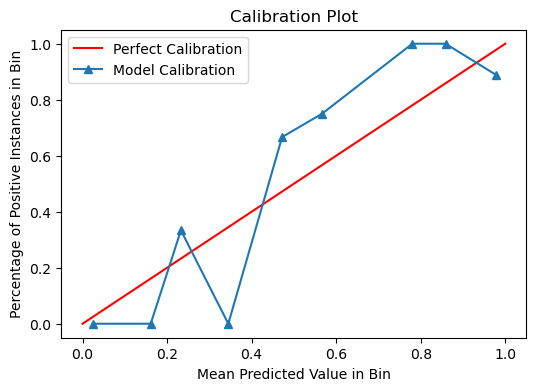

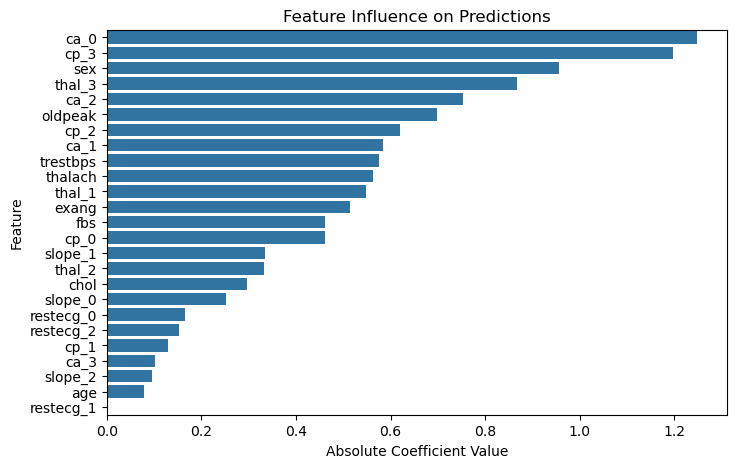

In [43]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plot
import seaborn

#Calibration Plot
PPIB, MPV=calibration_curve(testClasses, probabilities, n_bins=10)
plot.figure(figsize=(6, 4))
plot.plot([0, 1], [0, 1], linestyle='-', color='red', label='Perfect Calibration')
plot.plot(MPV, PPIB, marker='^', label='Model Calibration')
plot.xlabel('Mean Predicted Value in Bin')
plot.ylabel('Percentage of Positive Instances in Bin')
plot.title('Calibration Plot')
plot.legend()
plot.show()

#Feature Influence Bar Graph
featureCoefficients=np.abs(bestModel.coef_[0])
featureInfluence=pd.DataFrame({
    'Feature': features.columns,
    'Influence': featureCoefficients})
featureInfluence = featureInfluence.sort_values(by='Influence', ascending=False)
plot.figure(figsize=(8, 5))
seaborn.barplot(x='Influence', y='Feature', data=featureInfluence)
plot.xlabel('Absolute Coefficient Value')
plot.ylabel('Feature')
plot.title('Feature Influence on Predictions')
plot.show()


Metrics play a critical role in evaluating the model's performance, but they do no provide the entire story. That is where plots come into the fray. Here, we set up two plots to help us evaluate the model: a calibration plot and feature influence bar graph.

The calibration plot helps us see how nicely the model's predictions correlate with the true labels. That is, for all the samples the model predicts a probability of 0.93, 93% of the samples should be positive. Ideally, we want the model's calibration to match a perfectly calibrated model. We'll notice that the plot is undercalibrated for lower probabilities and overcalibrated for higher probabilities. Overall, the model is poorly calibrated, which aligns with its less than stellar metrics. 

The feature influence bar graph is quite self-explanatory. Although the model was quite mediocre with its predictions, its interesting to see what features influenced it the most. Of particular interest, is the fact that sex was a pretty influential feature because heart diseases are known to be sex-differentiated (which is what my past research explored, so it's cool to see it here).

For the complete project, we intend to explore more plots than the ones covered here. 
